## Задача и вводные

В этом проекте предстоит решить комплексную аналитическую задачу. Наш заказчик - разработчик мобильного приложения для домашних тренировок ("Заказчик"). Это мобильное приложение предназначено для заботы о здоровье и физической форме. Сейчас Заказчик сфокусирован на масштабировании бизнеса и активно старается выходить на новые рынки. Важность локализации заключается в том, что она позволяет нам учитывать особенности языка и культуры каждого региона, что улучшает опыт использования приложения для каждого пользователя. Мы можем измерить эффект от внедрения локализации, используя различные метрики, такие как количество загрузок приложения, количество пользователей, которые начали использовать приложение после локализации, их платежное поведение, удержание и др. В целях сохранения конфиденциальности наименования стран и язык локализации были зашифрованы. В датасете будут использованы параметры country и lang для обозначения принадлежности пользователя конкретной группе.

Кейс выглядит следующим образом: 2 года назад Заказчик запустил мобильное приложение для фитнеса в домашних условиях. В качестве MVP была разработана версия на одном языке для всех стран. Далее, в качестве эксперимента было принято решение перевести функционал приложения и контент и запустить в стране 2 локализацию на языке 2. Сейчас бизнес хочет запустить локализацию в новой стране и интересуется, был ли эксперимент успешен и как запуск новой локализации может повлиять на метрики страны 3. Тем временем, стороннее агенство предлагает локализовать приложение для страны 3 за 2.4 млн рублей. Сколько нового трафика надо будет привести в приложение, чтобы эта локализация окупилась на 100% ?

Для решения задачи имеются следующие данные:

app_installs_processed.csv - профили пользователей: username, дата регистрации, ОС устройства, язык локали, страна

logins_processed.csv - запуски приложения: username, дата входа, дата-время начала сессии, дата-время конца сессии

payments_processed.csv - платежи: username, pay_dt, дата-время платежа, сумма платежа, валюта

cbr_rates.xlsx - справочик курсов валют по датам

В ходе исследования необходимо:

1. выяснить, как изменилось удержание Retention30 пользователей, которые начали использовать приложение на родном языке;   
2. выяснить, как изменилось LTV180 пользователей, которые начали использовать приложение на родном языке;
3. предположить, насколько изменится LTV180 пользователей страны 3, если мы запустим на них локализацию;
4. вычислить, сколько новой аудитории нужно привлечь, чтобы локализация окупилась в течение 6 месяцев;
5. провести статистический тест различий LTV методом bootstrap;
5. сделать выводы о результатах исследования для Заказчика.

Для исследования успешности эксперимента в стране 2 необходимо сравнить 2 группы пользователей: пользователи из country_2, которые пользуются lang_1 и пользователи из country_2, которые пользуются lang_2.

In [39]:
import pandas as pd
import numpy as np
from datetime import datetime as dt, timedelta as tdt
import matplotlib.pyplot as plt
import scipy.stats as st
from scipy.stats import bootstrap

# Показать все столбцы
pd.set_option('display.max_columns', None)

## Cправочик курсов валют по датам

In [40]:
currency = pd.read_excel('C:/Users/Anna/Downloads/15/cbr_rates.xlsx')
# Исправим тип данных на корректный тип данных (на datetime64[ns])
currency['date'] = pd.to_datetime(currency['date'])
currency['rate_dt'] = pd.to_datetime(currency['rate_dt'])
currency_v2 = currency.copy()
# Сформируем таблицу c курсом доллара, отсортируем ее по дате
usd_currency = currency_v2[currency_v2['charcode'] == 'USD'].sort_values('rate_dt').reset_index(drop = True)
currency.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 916 entries, 0 to 915
Data columns (total 8 columns):
 #   Column    Non-Null Count  Dtype         
---  ------    --------------  -----         
 0   date      916 non-null    datetime64[ns]
 1   valute    916 non-null    object        
 2   numcode   916 non-null    int64         
 3   charcode  916 non-null    object        
 4   nominal   916 non-null    int64         
 5   name      916 non-null    object        
 6   value     916 non-null    float64       
 7   rate_dt   916 non-null    datetime64[ns]
dtypes: datetime64[ns](2), float64(1), int64(2), object(3)
memory usage: 57.4+ KB


## Профили пользователей

In [41]:
# профили пользователей: username, дата регистрации, ОС устройства, язык локализации, страна
profiles = pd.read_csv('C:/Users/Anna/Downloads/15/app_installs_processed.csv')

# Исправим тип данных на корректный тип данных (на datetime64[ns])
profiles['register_ts'] = pd.to_datetime(profiles['register_ts'])
profiles['day_reg'] = pd.to_datetime(profiles['day_reg'])

# создадим копию таблицы
profiles_v2 = profiles.copy()

# Отсортируем профили пользователей по дате и времени регистрации, сбросим индексы, удалим столбец со старыми индексами
profiles_v2  = profiles_v2.sort_values('register_ts').reset_index(drop = True)

# найти дубликаты
    #во всех столбцах дубликаты 
total_duplicate = profiles_v2[profiles_v2.duplicated()] #Их нет
    #в определенных столбцах дубликаты 
username_duplicate = profiles_v2[profiles_v2.duplicated(['username'])] #Есть
username_register_ts_duplicate = profiles_v2[profiles_v2.duplicated(['username', 'register_ts'])] #Их нет

profiles_cleaned = profiles_v2.copy()

# Удалим все дубликаты по username согласно заданию
profiles_cleaned = profiles_cleaned.drop_duplicates(subset=['username'], keep=False)

# Создадим массив стран и отсортируем его по возрастанию 
countries = profiles_cleaned['country'].unique()
countries = np.sort(countries)

# Вычислим в цикле количество пользователей в каждой стране (после удаленных дубликатов)
c1 = 0
c2 = 0
c3 = 0

for index, row in profiles_cleaned.iterrows():
    if row['country'] == countries[0]:
        c1+=1
    elif row['country'] == countries[1]:
        c2+=1
    elif row['country'] == countries[2]:
        c3+=1

print(f'Для {countries[0]} число пользователей равно {c1}, для {countries[1]} - {c2}, для {countries[2]} - {c3} (после удаленных дубликатов)')


# Создадим массив языков страны 2 и отсортируем его по возрастанию 
country2 = profiles_cleaned[profiles_cleaned['country'] == 'country2']
langs = country2['lang'].unique()
langs = np.sort(langs)
# Посчитаем количество пользователей по языку в стране 2 (после удаленных дубликатов)
l1 = 0
l2 = 0

for index, row in country2.iterrows():
    if row['lang'] == langs[0]:
        l1+=1
    elif row['lang'] == langs[1]:
        l2+=1
    
print(f'Для {langs[0]} число пользователей равно {l1}, для {langs[1]} - {l2} (после удаленных дубликатов)')

# Сформируем датафреймы пользователей из страны 2 на разных языках, а также датафрейм для страны 3
users_country2_lang1 = profiles_cleaned[(profiles_cleaned['country'] == 'country2') & (profiles_cleaned['lang'] == 'lang1')]
users_country2_lang2 = profiles_cleaned[(profiles_cleaned['country'] == 'country2') & (profiles_cleaned['lang'] == 'lang2')]
users_country3 = profiles_cleaned[(profiles_cleaned['country'] == 'country3')]
# Перезагрузим их индексы
users_country2_lang1.reset_index(drop = True, inplace = True)
users_country2_lang2.reset_index(drop = True, inplace = True)
users_country3.reset_index(drop = True, inplace = True)

Для country1 число пользователей равно 1698, для country2 - 9841, для country3 - 4238 (после удаленных дубликатов)
Для lang1 число пользователей равно 3403, для lang2 - 6438 (после удаленных дубликатов)


## Запуски приложения


In [42]:
# запуски приложения: username, дата входа, дата-время начала сессии, дата-время конца сессии

starts = pd.read_csv('C:/Users/Anna/Downloads/15/logins_processed.csv')
# Изменим тип данных с датами и временем (вместо object - datetime64[ns])
starts_columns_to_date = ['login_dt', 'login_ts', 'logout_ts']
starts[starts_columns_to_date] = starts[starts_columns_to_date].astype("datetime64[ns]")

# Создадим копию таблицы
starts_v2 = starts.copy()

## Платежи


In [43]:
#  платежи: username, pay_dt, дата-время платежа, сумма платежа, валюта
payments = pd.read_csv('C:/Users/Anna/Downloads/15/payments_processed.csv')
# Изменим тип данных с датами и временем (вместо object - datetime64[ns])
payments['pay_time_dttm'] = pd.to_datetime(payments['pay_time_dttm'])
payments['pay_dt'] = pd.to_datetime(payments['pay_dt'])

# Для вычисления накопительной выручки и LTV предварительно нужно привести все суммы платежей в рубли
# Используем курс валюты на конкретную дату из справочника

# Сделаем глубокие копии таблицы с платежами
payments_usd = payments.copy()
payments_rub = payments.copy()

# Обработаем таблицу с платежами в долларах
    # Сохраним в таблице только платежи в долларах
payments_usd = payments_usd[payments_usd['currency'] == 'usd']
    # Соединим таблицу платежей с таблицей курсов валют
payments_usd_rates = payments_usd.merge(usd_currency, left_on = 'pay_dt', right_on = 'rate_dt', how = 'left')
    # Переведем платеж в рубли
payments_usd_rates['pay_in_rub'] = round(payments_usd_rates['pay_amt']*payments_usd_rates['value'],2)
    #Скроем ненужные столбцы
payments_usd_rates_v2 = payments_usd_rates[['username', 'pay_dt', 'pay_time_dttm', 'pay_amt', 'currency', 'value', 'pay_in_rub']].copy()

# Обработаем таблицу с платежами в рублях
    # Сохраним в таблице только платежи в рублях
payments_rub_v2 = payments_rub[payments_rub['currency'] == 'rub'].copy()

# Объединим в таблицу таблицы с платежами в рублях и долларах
payments_total = pd.concat([payments_usd_rates_v2, payments_rub_v2])
# Продублируем значения операций в столбце 'pay_in_rub' 
payments_total.loc[payments_total['currency'] == 'rub', 'pay_in_rub'] = payments_total.loc[payments_total['currency'] == 'rub', 'pay_amt']
payments_total_by_day = payments_total.reset_index(drop = True).copy()

# Найдем общую сумму платежей по пользователям по дням и переименуем столбец
payments_total_by_day = payments_total_by_day.groupby(['username', 'pay_dt'])['pay_in_rub'].sum().reset_index()
payments_total_by_day = payments_total_by_day.rename(columns = {'pay_in_rub':'revenue_per_day'})
# Скроем лишние столбцы
payments_total_by_day = payments_total_by_day[['username', 'pay_dt', 'revenue_per_day']]


## Retention30

Дата самого позднего входа в приложение - 2023-06-25 00:00:00 
Предельная дата для фильтра пользователей для retention30 - 2023-05-26 00:00:00
Количество пользователей для расчета retention30: 3403
Площадь под кривой Retention составляет 6.64

Дата самого позднего входа в приложение - 2023-06-26 00:00:00 
Предельная дата для фильтра пользователей для retention30 - 2023-05-27 00:00:00
Количество пользователей для расчета retention30: 5946
Площадь под кривой Retention составляет 7.41

Для пользователей, которые начали использовать приложение на родном языке (язык 2), показатель retention30 повысился: на 30 день разница составляет 10.27 %


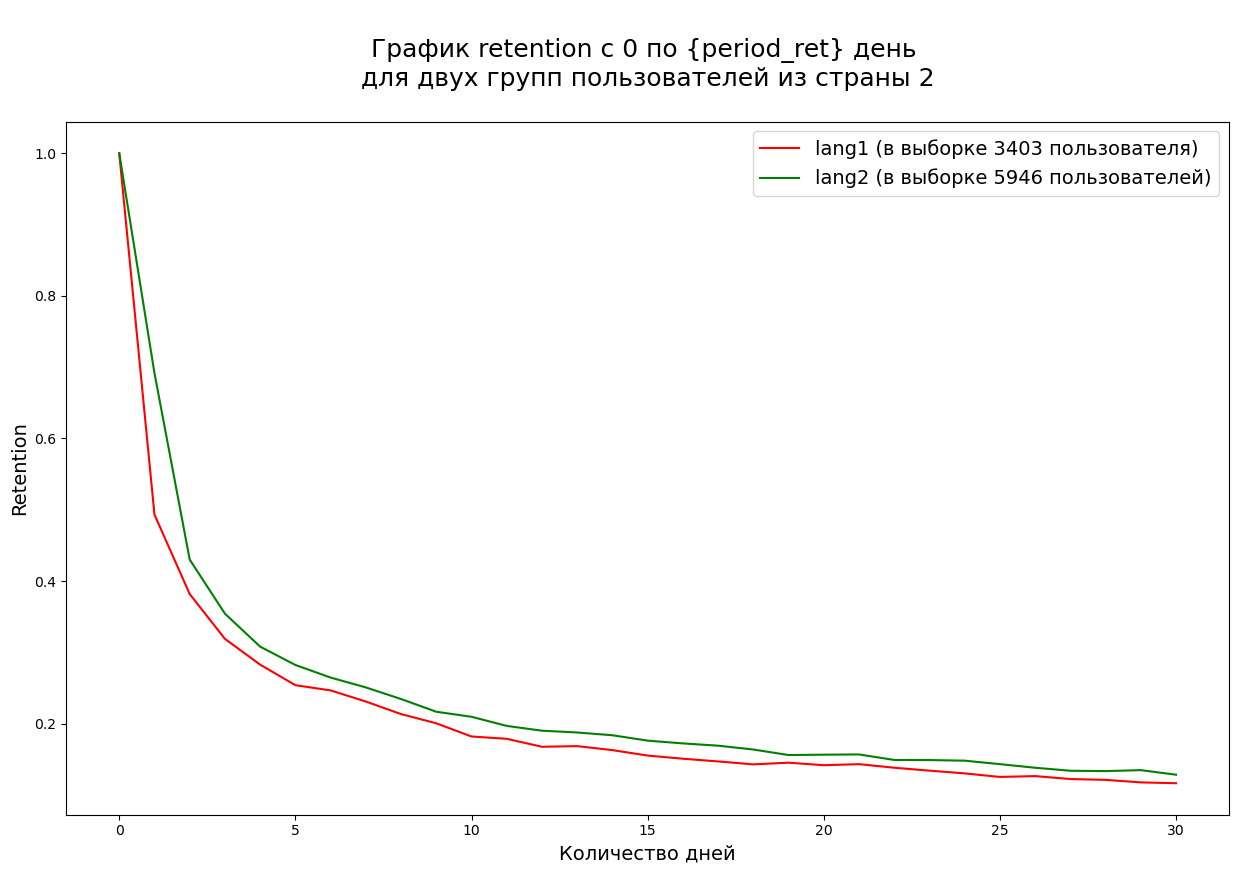

In [44]:
# Выясним, как изменилось удержание Retention30 пользователей в стране 2, которые начали использовать приложение на родном языке (язык 2)

# Соединим две таблицы (профили и запуски приложения, очищенные от дублей) по столбцу username 
# Страна 2 язык 1
users_country2_lang1_v2 = users_country2_lang1.copy()
starts_country2_lang1_v2 = users_country2_lang1_v2.merge(starts_v2, left_on = 'username', right_on = 'username', how = 'left')
# Страна 2 язык 2
users_country2_lang2_v2 = users_country2_lang2.copy()
starts_country2_lang2_v2 = users_country2_lang2_v2.merge(starts_v2, left_on = 'username', right_on = 'username', how = 'left')

#Скроем ненужные столбцы. Отсортируем значения по юзеру, а также дате входа в сессию
c2_l1 = starts_country2_lang1_v2[['username','register_ts', 'day_reg', 'login_dt', 'login_ts', 'logout_ts']].sort_values(['username', 'login_ts']).reset_index(drop=True).copy()
c2_l2 = starts_country2_lang2_v2[['username','register_ts', 'day_reg', 'login_dt', 'login_ts', 'logout_ts']].sort_values(['username', 'login_ts']).reset_index(drop=True).copy()

# Замена значений в столбце 'login_dt' на дату регистрации, если значение равно NaT (т.е. пользователь ни разу не заходил в приложение после регистрации)
c2_l1.loc[c2_l1['login_dt'].isnull(), 'login_dt'] = c2_l1['day_reg']
c2_l2.loc[c2_l2['login_dt'].isnull(), 'login_dt'] = c2_l2['day_reg']

# Заполним новый столбец разницей между датой входа в приложение и датой регистрации
c2_l1['time_period'] = c2_l1.login_dt - c2_l1.day_reg
c2_l2['time_period'] = c2_l2.login_dt - c2_l2.day_reg

# Напишем функцию для расчета retention: 
# в качестве аргумента необходимо указать датафрейм и период в днях, за который нужно расчитать retention
def calculate_retention (df, period):
             # Посчитаем максимальную дату входа пользователя в приложение
             maxdate = df['login_dt'].max() 
             # Выбираем дату последнего входа пользователя и вычитаем из нее кол-во дней, которое задано в period (например 30) 
             # Эта дата будет максимально допустимой датой регистрации пользователя для расчета retention
             maxdate_ret = maxdate - tdt(days=period)
             print(f'Дата самого позднего входа в приложение - {maxdate} \nПредельная дата для фильтра пользователей для retention{period} - {maxdate_ret}')
             # Отфильтруем пользователей, чтобы регистрация была не позднее максимальной даты
             users_filtered = df[df['day_reg'] <= maxdate_ret]
             # Подсчитаем общее количество пользователей для day0: 
                 # поскольку не все пользователи зашли в приложение в дату регистрации, 
                 # при дальнейшей группировке по дням вхождения в приложение в day0 получится некорректное значение
             users_0day = len(users_filtered['username'].unique())
             print(f'Количество пользователей для расчета retention{period}: {users_0day}')
             # Отсортируем по пользователям и по возрастанию даты, сделаем копию
             df_cleaned = users_filtered.sort_values(['username', 'login_dt', 'login_ts']).reset_index(drop = True).copy()
             # Удалим дубликаты множественного входа в одну дату одного пользователя для диаграммы retention (оставим первое вхождение в одну дату)
             df_cleaned  = df_cleaned.drop_duplicates(subset=['username', 'time_period'], keep='first')
             # Расчитаем количество пользователей в конкретный день входа в приложение
             users_by_period = df_cleaned.groupby('time_period')['username'].nunique().reset_index().copy()
             # Есть пользователи, которые не заходили в приложение в дату регистрации, заходили в другой день
             # В таком случае в таблице они не будут посчитаны в day0
             # Нам нужно приравнять количество пользователей в 0 день к количеству уникальных пользователей, которых мы посчитали выше
             # Заменим первую строку таблиц с количеством пользователей в нулевой день в ручную (кол-во уникальных пользователей мы считали выше)
             users_by_period.at[0, 'username'] = users_0day
             # Отфильтруем значения в таблице, чтобы time_period не превышал количество дней, за сколько нужно посчитать retention
             users_ret = users_by_period[users_by_period['time_period'] <= tdt(days=period)].copy()
             # Преобразуем значение в столбце time-period в тип данных целое число
             users_ret['time_period'] = users_ret['time_period'].apply(lambda x: x.days)
             # Создадим новый столбец с показателем retention для каждого дня
             users_ret['retention'] = users_ret['username']/users_0day
             # Вычислим площадь под кривой Retention (сумма по столбцу Retention, начиная с 0 дня)
             s = round(users_ret['retention'].sum(),2)
             print(f'Площадь под кривой Retention составляет {s}')
             print('')
             return users_ret
             
# Расчитаем retention с 0 по 30 день для обеих групп пользователей страны 2
period_ret = 30
c2_l1_ret = calculate_retention(c2_l1, period_ret)
c2_l2_ret = calculate_retention(c2_l2, period_ret)

# Определим разницу между retention 30 дня для двух групп пользователей (в процентах)
ret_dif = round(c2_l2_ret.at[period_ret, 'retention']/c2_l1_ret.at[period_ret, 'retention']*100-100,2)

# Нарисуем график retention 0-30 дней для двух групп пользователей страны 2 
plt.figure(figsize=(15, 9))
plt.plot(c2_l1_ret['time_period'], c2_l1_ret['retention'],  label=f"lang1 (в выборке {c2_l1_ret.at[0, 'username']} пользователя)", color = 'red')
plt.plot(c2_l2_ret['time_period'], c2_l2_ret['retention'],  label=f"lang2 (в выборке {c2_l2_ret.at[0, 'username']} пользователей)", color = 'green')
plt.xlabel('Количество дней', fontsize = 14) 
plt.ylabel('Retention', fontsize = 14)
plt.title('\nГрафик retention c 0 по {period_ret} день \nдля двух групп пользователей из страны 2\n', fontsize = 18) 

plt.legend(fontsize = 14)
plt.grid(False)

print(f'Для пользователей, которые начали использовать приложение на родном языке (язык 2), показатель retention{period_ret} повысился: на {period_ret} день разница составляет {ret_dif} %')


## LTV 180 (страна 2 и страна 3)

Без фильтрации по дате регистрации пользователя выручка по всей группе lang 1 составляет 2.3 млн. руб., по группе lang 2 - 5.06 млн. руб.

Для целей расчета LTV180 количество пользователей в day0 составляет 3403 пользователя

Для целей расчета LTV180 количество пользователей в day0 составляет 3301 пользователя

В сравнении с группой язык 1 для группы язык 2 показатель ltv180 увеличился на 90% или в 1.9 раз

Для целей расчета LTV180 количество пользователей в day0 составляет 2844 пользователя

Базовый показатель LTV180 для страны 3 составляет 378.16

В случае если после локализации приложения в стране 3 показатель LTV180 также увеличится в 1.9 раз, показатель LTV180 составит 718.5

Чтобы локализация приложения в стране 3 окупилась за полгода, нужно привести 3340 новых пользователей



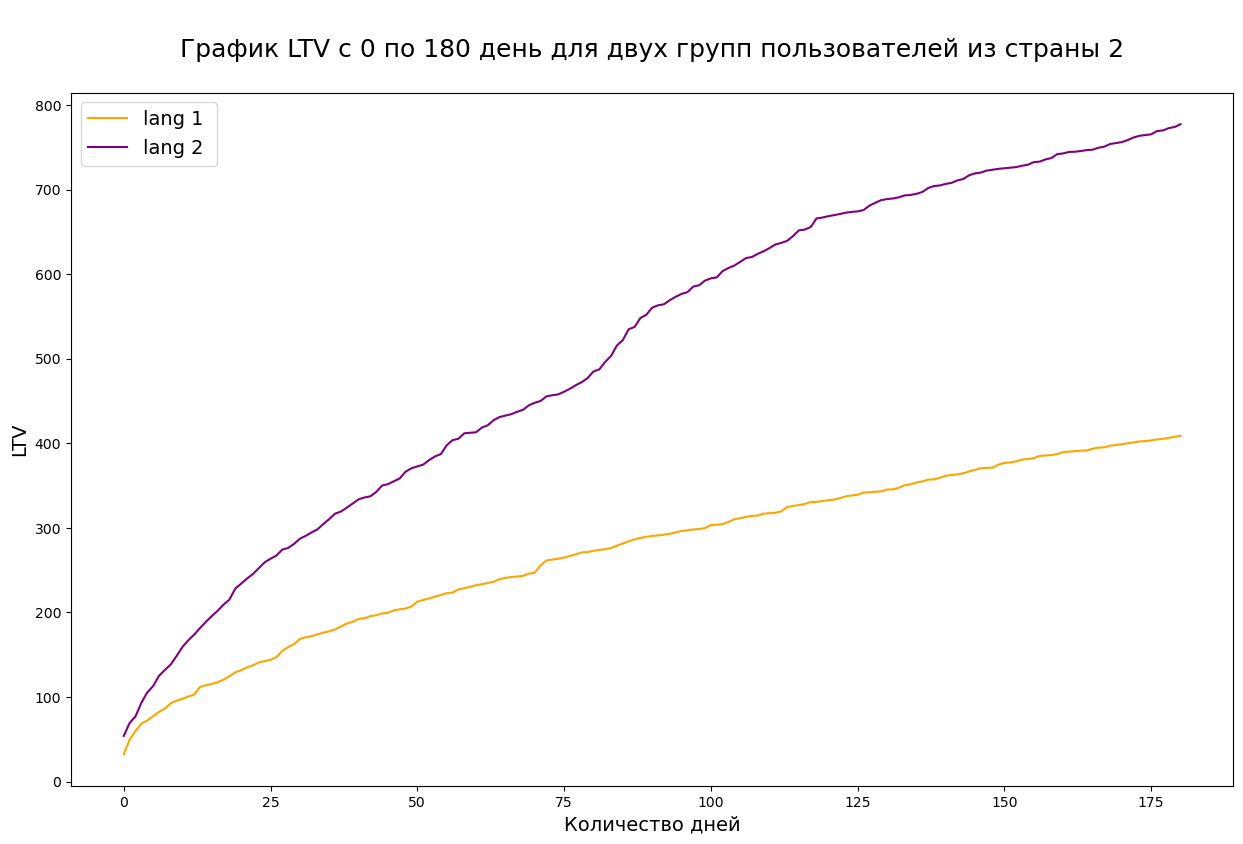

In [45]:
users_country2_lang1_v3 = users_country2_lang1.copy()
users_country2_lang2_v3 = users_country2_lang2.copy()
users_country3_v2 = users_country3.copy()

# К таблицам с профилями пользователей (очищены от дублей) по стране 2 и 3 присоединим таблицу с платежами в рублях
payments_c2l1_new = users_country2_lang1_v3.merge(payments_total_by_day, left_on = 'username', right_on = 'username', how = 'left')
payments_c2l2_new = users_country2_lang2_v3.merge(payments_total_by_day, left_on = 'username', right_on = 'username', how = 'left')
payments_c3 = users_country3_v2.merge(payments_total_by_day, left_on = 'username', right_on = 'username', how = 'left')

# Найдем общую выручку по каждой из групп страны 2 (до фильтрации по дате регистрации для расчета LTV180)
total_revenue_c2l1_new = round(payments_c2l1_new['revenue_per_day'].sum()/1000000,2)
total_revenue_c2l2_new = round(payments_c2l2_new['revenue_per_day'].sum()/1000000,2)

print(f'Без фильтрации по дате регистрации пользователя выручка по всей группе lang 1 составляет {total_revenue_c2l1_new} млн. руб., по группе lang 2 - {total_revenue_c2l2_new} млн. руб.')
print('')

# Добавим в таблицу количество дней, прошедшее с даты платежа для каждого пользователя
payments_c2l1_new['payment_period'] = payments_c2l1_new['pay_dt'] - payments_c2l1_new['day_reg']
payments_c2l2_new['payment_period'] = payments_c2l2_new['pay_dt'] - payments_c2l2_new['day_reg']
payments_c3['payment_period'] = payments_c3['pay_dt'] - payments_c3['day_reg']

# Напишем функцию для расчета LTV: 
# в качестве аргумента необходимо указать датафрейм и период в днях, за который нужно расчитать LTV
def calculate_ltv (df, period):
             # Найдем последнюю дату платежа по каждой группе
             last_payment_date = df['pay_dt'].max()
             # Вычислим дату, которая будет максимально допустимой датой регистрации пользователя для расчета LTV
             maxdate = last_payment_date - tdt(days=period)
             # Отфильтруем пользователей по дате регистрации для расчета LTV
             # (уберем пользователей, которые зарегистрировались позднее максимальной даты)
             payments_filtered = df[df['day_reg'] <= maxdate].copy()
             # Преобразуем значение в столбце payment_period в тип данных целое число
             payments_filtered['payment_period'] = payments_filtered['payment_period'].apply(lambda x: x.days)
             # Посчитаем количество уникальных пользователей для обеих групп (день 0) - включает всех пользователей (в т.ч. тех, кто не платил)
             users_0day = len(payments_filtered['username'].unique())
             print(f'Для целей расчета LTV{period} количество пользователей в day0 составляет {users_0day} пользователя')
             print('')                            
             # Посчитаем суммарную валовую прибыль от всей когорты пользователей в динамике по дням с момента регистрации
             payments_filtered_2 = payments_filtered.copy()
             revenue_by_day = payments_filtered_2.groupby(['payment_period'])['revenue_per_day'].sum().reset_index()
             # Посчитаем кумулятивную валовую прибыль от всей когорты пользователей в динамике по дням с момента регистрации
             revenue_by_day['cum_profit'] = revenue_by_day['revenue_per_day'].cumsum().reset_index(drop = True)           
             # Для расчета LTV оставим в таблице дни от 0 до period                
             cum_revenue = revenue_by_day.copy()
             cum_revenue = cum_revenue[cum_revenue['payment_period'] <= period]
             # Делим кумулятивную валовую прибыль на общее количество пользователей и получаем динамику LTV когорты пользователей по дням
             cum_revenue['ltv_per_day'] = cum_revenue['cum_profit']/users_0day                          
             return cum_revenue


# Расчитаем LTV180 для обеих групп пользователей страны 2
period_ltv = 180
c2_l1_ltv = calculate_ltv(payments_c2l1_new, period_ltv)
c2_l2_ltv = calculate_ltv(payments_c2l2_new, period_ltv)

# Расчитаем, на сколько процентов увеличился показатель LTV180 для пользователей из группы язык 2 по сравнению с группой язык 1
dif_percent_new = round(c2_l2_ltv.at[180, 'ltv_per_day']/c2_l1_ltv.at[period_ltv, 'ltv_per_day']*100-100)
# Расчитаем, во сколько раз увеличился показатель LTV180 для пользователей из группы язык 2 по сравнению с группой язык 1
dif_new = round(c2_l2_ltv.at[180, 'ltv_per_day']/c2_l1_ltv.at[period_ltv, 'ltv_per_day'],2)
print(f'В сравнении с группой язык 1 для группы язык 2 показатель ltv180 увеличился на {dif_percent_new}% или в {dif_new} раз')
print('')

# Определим показатель LTV180 для страны 3
c3_ltv = calculate_ltv(payments_c3, period_ltv)
ltv180_c3 = round(c3_ltv.at[period_ltv, 'ltv_per_day'],2)
print(f'Базовый показатель LTV180 для страны 3 составляет {ltv180_c3}')
print('')

# Прогноз LTV180 для страны 3 
ltv180_c3_new = round(ltv180_c3*dif_new,2)
print(f'В случае если после локализации приложения в стране 3 показатель LTV{period_ltv} также увеличится в {dif_new} раз, показатель LTV{period_ltv} составит {ltv180_c3_new}')
print('')

# Расчитаем, сколько необходимо привести новых пользователей в стране 3, чтобы локализация приложения окупилась за 6 месяцев
cost = 2400000 #Стоимость локализации в руб.
count_new_users_c3 = round(cost/ ltv180_c3_new)
print(f'Чтобы локализация приложения в стране 3 окупилась за полгода, нужно привести {count_new_users_c3} новых пользователей')
print('')

# Нарисуем график lTV180 для двух групп пользователей: страны 2 язык 1 и страны 2 язык 2
plt.figure(figsize=(15, 9))
plt.plot(c2_l1_ltv['payment_period'], c2_l1_ltv['ltv_per_day'],  label=f"lang 1 ", color = 'orange')
plt.plot(c2_l2_ltv['payment_period'], c2_l2_ltv['ltv_per_day'],  label=f"lang 2 ", color = 'purple')
plt.xlabel('Количество дней', fontsize = 14) 
plt.ylabel('LTV', fontsize = 14)
plt.title(f'\nГрафик LTV c 0 по {period_ltv} день для двух групп пользователей из страны 2\n', fontsize = 18) 

plt.legend(fontsize = 14)
plt.grid(False)

## Bootstrap

In [46]:
# Проведем статистический тест различий LTV методом bootstrap
# Для этого подготовим таблицу, в которой у каждого пользователя будет посчитано LTV180 и указан язык (user - LTV180 - lang)

# Создадим глубокие копии списков пользователей
us_c2l1_boot = payments_c2l1_new.copy()
us_c2l2_boot = payments_c2l2_new.copy()

period_ltv = tdt(days=180)

# Отфильтруем строки входа пользователей (оставим с 0 по 180 дня после регистрации)
us_c2l1_boot  = us_c2l1_boot [us_c2l1_boot ['payment_period'] <= period_ltv]
us_c2l2_boot  = us_c2l2_boot [us_c2l2_boot ['payment_period'] <= period_ltv]

# Вычислим кумулятивно LTV180 для каждого пользователя: 
# если у пользователя нет платежей на 180 день, берем для него последнее (максимальное) значение

us_c2l1_boot = us_c2l1_boot.groupby(['username'])['revenue_per_day'].sum().reset_index()
us_c2l2_boot = us_c2l2_boot.groupby(['username'])['revenue_per_day'].sum().reset_index()
us_c2l1_boot = us_c2l1_boot.rename(columns = {'revenue_per_day':'ltv180_for_user'})
us_c2l2_boot = us_c2l2_boot.rename(columns = {'revenue_per_day':'ltv180_for_user'})
# Добавим указание на язык в таблицу
us_c2l1_boot['lang'] = 'lang 1'
us_c2l2_boot['lang'] = 'lang 2'

# Соединим две группы в единую таблицу
all_users_boot = pd.concat([us_c2l1_boot, us_c2l2_boot])

#ЭТО ВООБЩЕ НАДО СЧИТАТЬ?
# Вычислим среднее значение ltv180 по группе 1 и группе 2
mean_boot = all_users_boot.groupby('lang')['ltv180_for_user'].mean()
mean_l1 = mean_boot['lang 1']
mean_l2 = mean_boot['lang 2']
print(mean_l1, mean_l2)

# сгенерируем новый датасет, который будут состоять из выборочных средних LTV180
# создаем список res, в который мы будем собирать выборочные средние;
res = [] 

#повторяем следующие шаги в цикле 1000 раз:
    #создаем новый датасет из случайных элементов:
    #выбираем наугад одно наблюдение из имеющихся;
    #повторяем выбор столько раз, сколько у нас есть наблюдений (при этом некоторые из них выберем несколько раз, некотороые не выберем вообще);
    #используем конструкцию ddf = df.sample(frac = 1, replace = True), 
    #где frac = 1 означает столько раз повторять выбор, сколько есть наблюдений;
for i in range(1000):
    ddf = all_users_boot.sample(frac = 1, replace = True)
    #вычисляем среднее значение ddf.groupby('lang')['ltv180_for_user'].mean() и сохраняем его в список с результатами из п.1 res.append();
    mean_boot = ddf.groupby('lang')['ltv180_for_user'].mean()
    res.append(mean_boot)
    
#преобразуем res в pd.DataFrame(), сбросим индексы, удалим старый индекс, уберем название столбца с индексом
df_means = pd.DataFrame(res).reset_index().drop('index', axis=1).rename_axis(None, axis=1)

df_means.head()

2016.798231884058 3940.2599664991626


,lang 1,lang 2
0,2423.454044,4505.907583
1,1970.967982,4373.500099
2,2139.125583,4676.028310
3,2099.896141,3654.063030
4,2168.670562,3562.818471


(1607.5785414991321, 2494.844942284866) (3354.757389841137, 4603.759988269669)
2016.2510735666815 3944.6967794286493


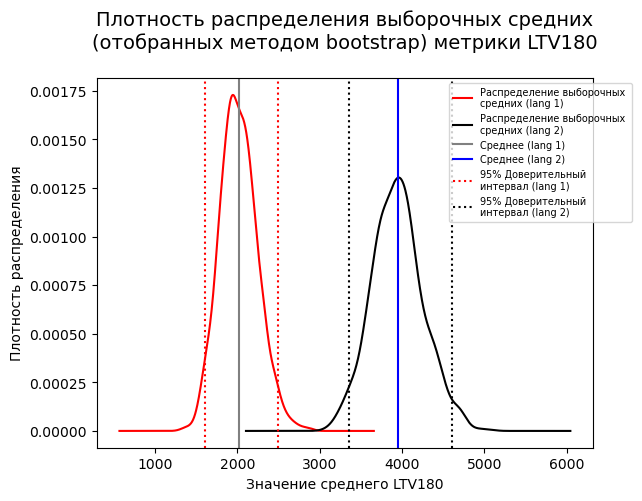

In [47]:
# Найдем 2.5 и 97.5 процентили в нашей выборке по каждой из групп
ci1 = df_means['lang 1'].quantile(0.025), df_means['lang 1'].quantile(0.975)
ci2 = df_means['lang 2'].quantile(0.025), df_means['lang 2'].quantile(0.975)
print(ci1, ci2)

# Вычислим средние выборочных средних обеих групп
mean_lang1 = np.mean(df_means['lang 1'])
mean_lang2 = np.mean(df_means['lang 2'])
print(mean_lang1, mean_lang2)

# Построим графики плотности распределения средних
df_means['lang 1'].plot.kde(color = 'red',  label = 'Распределение выборочных \nсредних (lang 1)')
df_means['lang 2'].plot.kde(color = 'black',  label = 'Распределение выборочных \nсредних (lang 2)')
# Средние
plt.axvline(x=mean_lang1, color = 'grey', label = 'Среднее (lang 1)')
plt.axvline(x=mean_lang2, color = 'blue',  label = 'Среднее (lang 2)')
# Построим 95% доверительные интервалы для обеих групп
plt.xlabel('Значение среднего LTV180', fontsize = 10) 
plt.ylabel('Плотность распределения', fontsize = 10)
plt.axvline(ci1[0], color='red', linestyle=':', label='95% Доверительный \nинтервал (lang 1)')
plt.axvline(ci1[1],  color='red', linestyle=':')
plt.axvline(ci2[0],  color='black', linestyle=':', label='95% Доверительный \nинтервал (lang 2)')
plt.axvline(ci2[1], color='black', linestyle=':')
# Заголовок и легенда
plt.title('Плотность распределения выборочных средних\n(отобранных методом bootstrap) метрики LTV180\n', fontsize = 14)
plt.legend(bbox_to_anchor=( 0.7 , 1 ), fontsize = 7, loc='upper left')

Поскольку 95% доверительные интервалы для обеих групп не пересекаются, различия LTV180 между двумя группами являются статистически значимыми. 